# **CSI 4142 Assignment 2 - Part 2: Imputation** ##
**Group 119:**\
Sami Hassan,
300169285\
Yassine Sami, 300146704

> # **Introduction**
The goal of this report is to explore, program and evaluate various data imputation methods in handling missing data in a dataset. In accomplishing this, we will be using a dataset that tracks sleeping habits in an effort to analyze their effect on productivity.

In [112]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# loading data set
df = pd.read_csv('https://raw.githubusercontent.com/yasssami/csi4142/master/datasets/sleep_cycle_productivity.csv')

> # **Dataset 2: Sleep Cycle & Productivity (Data Imputation Training)**

## Dataset Description
The dataset used for the imputation portion of Assignment 2 is called **"Sleep Cycle & Productivity"**, published by Ahmed Mohamed on Kaggle. This dataset contains multiple transactions made at a café with several missing values, inconsistent data and errors made for data cleaning. This dataset contains **5000** entries and **15** attributes.


The attributes outlined by the dataset:

*   **Date:** The date of data collection.
*   **Person_ID:** Unique identifier for each individual.
*   **Age:** Age of the person (18-60 years).
*   **Gender:** Male, female, or Other.
*   **Sleep Start Time:** Time when the person went to bed (in 24-hour format).
*   **Sleep End Time:** Time when the person woke up (in 24-hour format).
*   **Total Sleep Hours:** Total duration of sleep (in hours).
*   **Sleep Quality:** Self-reported sleep quality (scale: 1-10).
*   **Exercise (mins/day):** Minutes spent exercising per day.
*   **Caffeine Intake (mg):** Amount of caffeine consumed in mg.
*   **Screem Time Before Bed (mins):** Time spent using screens before sleeping.
*   **Work Hours (hrs/day):** Total working hours in a day.
*   **Productivity Score:** Self-reported productivity score (scale: 1-10).
*   **Mood Score:** Self-reported mood score (scale: 1-10).
*   **Stress Level:** Self-reported stress level (scale: 1-10).



In [111]:
# run an initial check on whether missing values already exist in the dataset
print("Missing values in the original dataset:")
print(df.isnull().sum())
df.head()
df.describe()

Missing values in the original dataset:
Date                             0
Person_ID                        0
Age                              0
Gender                           0
Sleep Start Time                 0
Sleep End Time                   0
Total Sleep Hours                0
Sleep Quality                    0
Exercise (mins/day)              0
Caffeine Intake (mg)             0
Screen Time Before Bed (mins)    0
Work Hours (hrs/day)             0
Productivity Score               0
Mood Score                       0
Stress Level                     0
dtype: int64


,Person_ID,Age,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,5527.152200,38.590600,22.005350,4.980262,6.974902,5.520800,43.962600,146.71140,91.421200,7.987873,5.644200,5.370600,5.548000
std,2595.391771,12.302799,1.157591,1.862508,1.454033,2.863845,25.798541,85.83139,52.079123,2.275734,2.872221,2.835783,2.888419
min,1000.000000,18.000000,20.000000,0.560000,4.500000,1.000000,0.000000,0.00000,0.000000,4.000067,1.000000,1.000000,1.000000
25%,3258.000000,28.000000,21.020000,3.660000,5.690000,3.000000,22.000000,73.00000,46.000000,6.032720,3.000000,3.000000,3.000000
50%,5603.000000,39.000000,22.020000,4.970000,6.960000,5.000000,44.000000,144.00000,92.000000,7.998295,6.000000,5.000000,6.000000
75%,7749.500000,49.000000,23.000000,6.310000,8.210000,8.000000,66.000000,220.00000,136.000000,9.905024,8.000000,8.000000,8.000000
max,9998.000000,59.000000,23.980000,9.420000,9.500000,10.000000,89.000000,299.00000,179.000000,11.999141,10.000000,10.000000,10.000000


> # **a) & b): Attribute of choice for imputation testing: Productivity Score**

### Our attribute has a relatively uniform distribution at baseline

Baseline stats for Productivity Score attribute:
count    5000.000000
mean        5.644200
std         2.872221
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: Productivity Score, dtype: float64


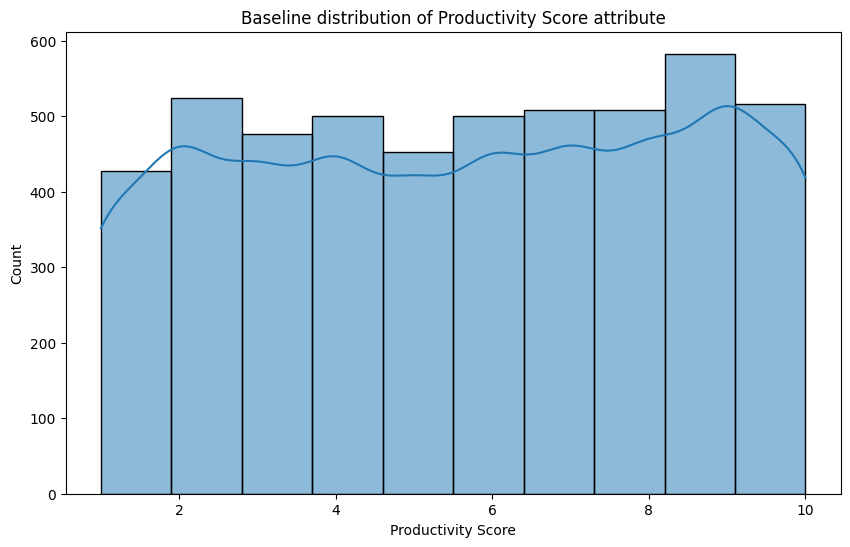

In [113]:
print("Baseline stats for Productivity Score attribute:")
print(df['Productivity Score'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['Productivity Score'], bins=10, kde=True)
plt.title('Baseline distribution of Productivity Score attribute')
plt.show()

# initialize copy for each test to take after
df_orig = df.copy()
productivity_values = df_orig['Productivity Score'].copy()
median_df = df_orig.copy()
reg_df = df_orig.copy()
knn_df = df_orig.copy()

## **Test 1:** Default value imputation using the mean with MCAR simulation

In [114]:
np.random.seed(42)
median = median_df['Productivity Score'].median()
print(f"Median value used for productivity imputation: {median}")

# void 20% of Productivity Score entries completely at random
replace_mcar = np.random.choice(median_df.index, size=int(len(median_df) * 0.2), replace=False)
median_df.loc[replace_mcar, 'Productivity Score'] = np.nan

# confirm removal
print(f"Number of missing productivity values created: {median_df['Productivity Score'].isnull().sum()} out of 5000 entries")
print(f"Percentage of missing productivity values: {median_df['Productivity Score'].isnull().mean() * 100:.2f}%")

# perform mean imputation
median_df['Productivity_Imputed'] = median_df['Productivity Score'].fillna(median)

# evaluate imputation
mcar_indices = replace_mcar.tolist()
mae_median, rmse_median = mean_absolute_error(productivity_values[mcar_indices], median_df.loc[mcar_indices, 'Productivity_Imputed']), np.sqrt(mean_squared_error(productivity_values[mcar_indices], median_df.loc[mcar_indices, 'Productivity_Imputed']))

print(f"Mean Absolute Error using Median Value Imputation: {mae_median:.2f}")
print(f"Root Mean Squared Error using Median Value Imputation: {rmse_median:.2f}")

Median value used for productivity imputation: 6.0
Number of missing productivity values created: 1000 out of 5000 entries
Percentage of missing productivity values: 20.00%
Mean Absolute Error using Median Value Imputation: 2.47
Root Mean Squared Error using Median Value Imputation: 2.86


#### Summary visualization for Test 1:

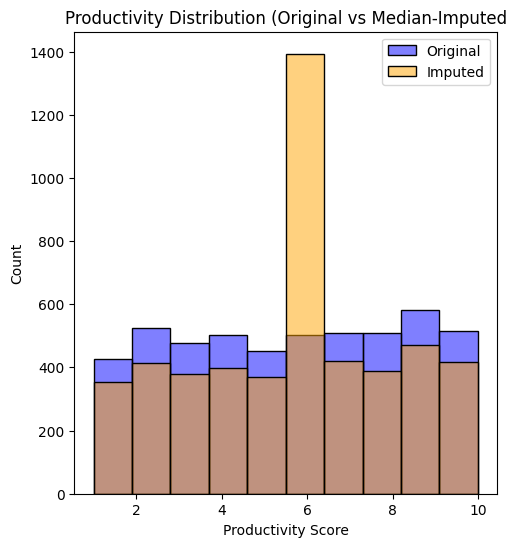

In [115]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(productivity_values, color='blue', alpha=0.5, label='Original', bins=10)
sns.histplot(median_df['Productivity_Imputed'], color='orange', alpha=0.5, label='Imputed', bins=10)
plt.title('Productivity Distribution (Original vs Median-Imputed')
plt.legend()

## **Test 2:** Regression imputation with MAR simulation

#### Simulation strategy: Increased likelihood of missing values depending on entry's reported stress level

In [116]:
np.random.seed(42)
miss_prob = np.clip(reg_df['Stress Level'] / 10, 5*10**-2, 5**-2*10)
mask_mar = np.random.rand(len(reg_df)) < miss_prob

# removal
reg_df.loc[mask_mar, 'Productivity Score'] = np.nan
print(f"Number of missing productivity values created: {reg_df['Productivity Score'].isnull().sum()}")
print(f"Percentage of missing productivity values: {reg_df['Productivity Score'].isnull().mean() * 100:.2f}%")

# quick check, avg stress level should be higher in entries w/ missing productivity
print("Avg Stress Level (Missing Productivity):", reg_df.loc[reg_df['Productivity Score'].isnull(), 'Stress Level'].mean())
print("Avg Stress Level (Untampered Productivity):", reg_df.loc[reg_df['Productivity Score'].notnull(), 'Stress Level'].mean())

Number of missing productivity values created: 1753
Percentage of missing productivity values: 35.06%
Avg Stress Level (Missing Productivity): 6.253850541928124
Avg Stress Level (Untampered Productivity): 5.166923313828149


#### **Predictor selection:** Sleep quality & amount, Hours worked, Stress levels, exercise & mood are all valid predictors for an expected productivity score

In [117]:
predictors = ['Sleep Quality', 'Total Sleep Hours', 'Exercise (mins/day)', 'Work Hours (hrs/day)', 'Mood Score', 'Stress Level']
reg = LinearRegression()
# split dataset into clean & tampered samples
train_data = reg_df.dropna(subset=['Productivity Score'])
train_X = train_data[predictors]
train_y = train_data['Productivity Score']

missing_data = reg_df[reg_df['Productivity Score'].isnull()]
test_X = missing_data[predictors]
reg.fit(train_X, train_y)

predict = reg.predict(test_X)
reg_df['Productivity_Imputed'] = reg_df['Productivity Score'].copy()
reg_df.loc[reg_df['Productivity Score'].isnull(), 'Productivity_Imputed'] = predict

# sanity check, clip values to 1-10 range
reg_df['Productivity_Imputed'] = np.clip(reg_df['Productivity_Imputed'], 1, 10)

# generate coefs relative to each predictor
for attribute, coef in zip(predictors, reg.coef_):
  print(f"Coefficient for {attribute}: {coef:.4f}")
print(f"Intercept: {reg.intercept_:4f}")

Coefficient for Sleep Quality: 0.0154
Coefficient for Total Sleep Hours: 0.0357
Coefficient for Exercise (mins/day): -0.0031
Coefficient for Work Hours (hrs/day): -0.0231
Coefficient for Mood Score: -0.0197
Coefficient for Stress Level: -0.0007
Intercept: 5.709691


In [118]:
# evaluation of regression imputation
mar_indices = mask_mar.tolist()
mae_reg, rmse_reg = mean_absolute_error(productivity_values[mar_indices], reg_df.loc[mar_indices, 'Productivity_Imputed']), np.sqrt(mean_squared_error(productivity_values[mar_indices], reg_df.loc[mar_indices, 'Productivity_Imputed']))

print(f"Mean Absolute Error using Regression Imputation: {mae_reg:.2f}")
print(f"Root Mean Squared Error using Regression Imputation: {rmse_reg:.2f}")

Mean Absolute Error using Regression Imputation: 2.50
Root Mean Squared Error using Regression Imputation: 2.86


#### Summary visualization for Test 2:

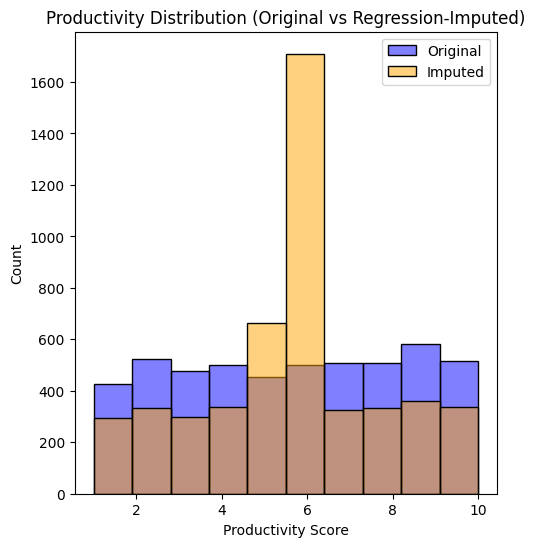

In [119]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(productivity_values, color='blue', alpha=0.5, label='Original', bins=10)
sns.histplot(reg_df['Productivity_Imputed'], color='orange', alpha=0.5, label='Imputed', bins=10)
plt.title('Productivity Distribution (Original vs Regression-Imputed)')
plt.legend()

## **Test 3:** Similarity-based imputation (KNN) with MNAR simulation

#### Simulation strategy: Increased likelihood of high productivity scores missing

In [120]:
np.random.seed(42)
miss_prob = knn_df['Productivity Score'] / knn_df['Productivity Score'].max()
mask_mnar = np.random.random(len(knn_df)) < miss_prob
knn_df.loc[mask_mnar, 'Productivity Score'] = np.nan


print(f"Number of missing productivity values created: {knn_df['Productivity Score'].isnull().sum()}")
print(f"Percentage of missing productivity values: {knn_df['Productivity Score'].isnull().mean() * 100:.2f}%")

knn_features = ['Age', 'Sleep Quality', 'Total Sleep Hours', 'Exercise (mins/day)',
               'Caffeine Intake (mg)', 'Work Hours (hrs/day)',
               'Screen Time Before Bed (mins)', 'Mood Score', 'Stress Level']
knn_df_sub = knn_df[knn_features + ['Productivity Score']].copy()

# scale
scaler = StandardScaler()
knn_df_sub[knn_features] = scaler.fit_transform(knn_df_sub[knn_features])

# apply knn imputation
imputer = KNNImputer(n_neighbors=5)
knn_df_imputed = pd.DataFrame(imputer.fit_transform(knn_df_sub), columns=knn_df_sub.columns)

# convert to initial scale
knn_df_imputed[knn_features] = scaler.inverse_transform(knn_df_imputed[knn_features])

# reinsert imputed values into orig. df
knn_df['Productivity_Imputed'] = knn_df_imputed['Productivity Score'].copy()
knn_df.loc[knn_df['Productivity Score'].isnull(), 'Productivity_Imputed'] = knn_df_imputed.loc[knn_df['Productivity Score'].isnull(), 'Productivity Score']

# sanity check, clip values to 1-10 range
knn_df['Productivity_Imputed'] = np.clip(knn_df['Productivity_Imputed'], 1, 10)

mnar_indices = mask_mnar.tolist()
mae_knn = mean_absolute_error(productivity_values[mnar_indices], knn_df.loc[mnar_indices, 'Productivity_Imputed'])
rmse_knn = np.sqrt(mean_squared_error(productivity_values[mnar_indices], knn_df.loc[mnar_indices, 'Productivity_Imputed']))

print(f"Mean Absolute Error using KNN Imputation: {mae_knn:.2f}")
print(f"Root Mean Squared Error using KNN Imputation: {rmse_knn:.2f}")

Number of missing productivity values created: 2840
Percentage of missing productivity values: 56.80%
Mean Absolute Error using KNN Imputation: 3.71
Root Mean Squared Error using KNN Imputation: 4.25


#### Summary visualization for Test 3:

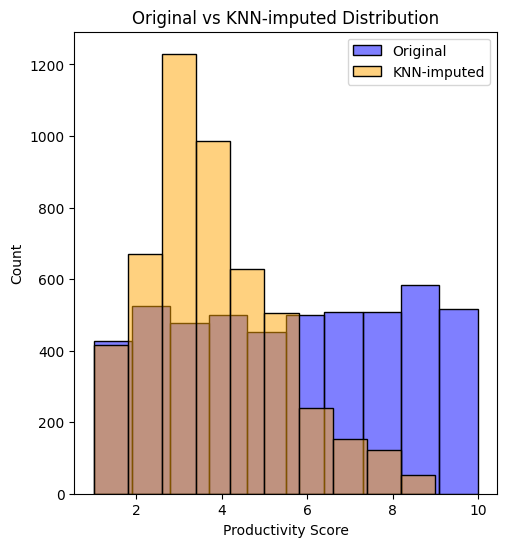

In [121]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(productivity_values, color='blue', alpha=0.5, label='Original', bins=10)
sns.histplot(knn_df['Productivity_Imputed'], color='orange', alpha=0.5, label='KNN-imputed', bins=10)
plt.title('Original vs KNN-imputed Distribution')
plt.legend()

## **Final Comparison:**

In [123]:
res = pd.DataFrame({
    'Method': ['Median Imputation (MCAR)', 'Regression Imputation (MAR)', 'KNN Imputation (MNAR)'],
    'MAE': [
        mae_median,
        mae_reg,
        mae_knn
    ],
    'RMSE': [
        rmse_median,
        rmse_reg,
        rmse_knn
    ]
})

print(res)

                        Method       MAE      RMSE
0     Median Imputation (MCAR)  2.466000  2.861818
1  Regression Imputation (MAR)  2.503271  2.860117
2        KNN Imputation (MNAR)  3.705282  4.247689


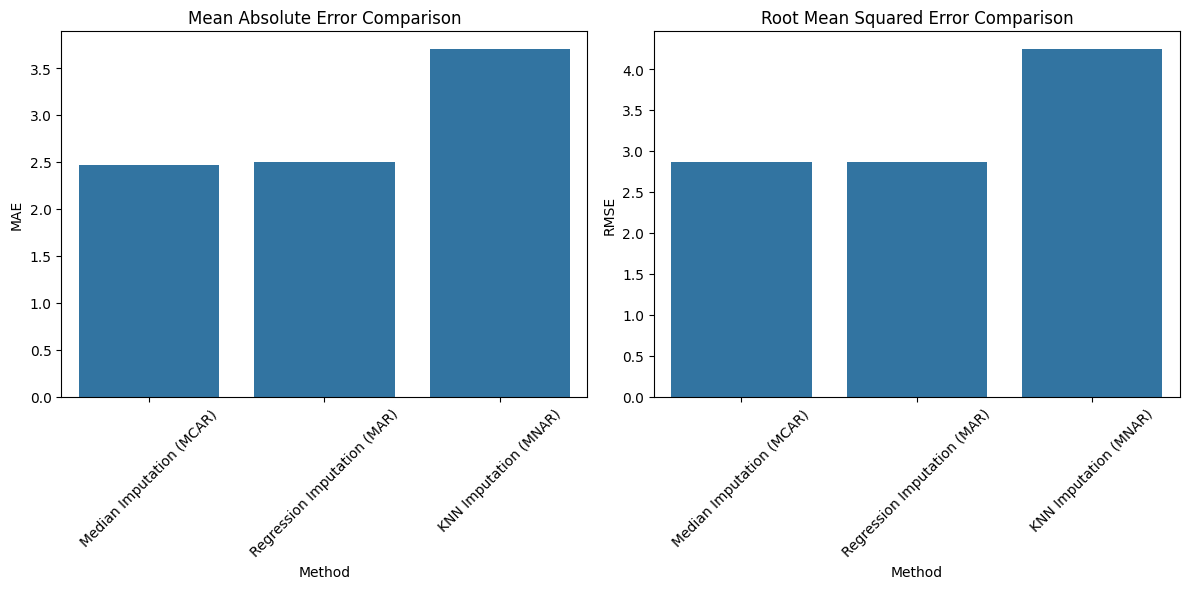

In [124]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Method', y='MAE', data=res)
plt.title('Mean Absolute Error Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.barplot(x='Method', y='RMSE', data=res)
plt.title('Root Mean Squared Error Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


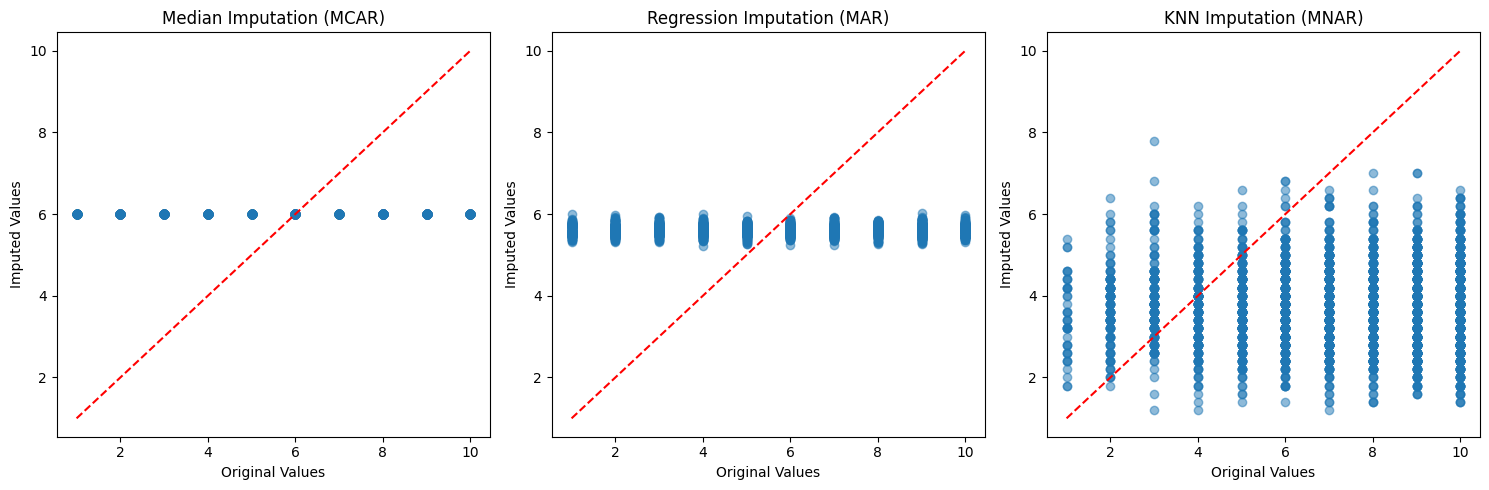

In [125]:
# combined scatterplot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(productivity_values[mcar_indices],
            median_df.loc[mcar_indices, 'Productivity_Imputed'],
            alpha=0.5)
plt.plot([1, 10], [1, 10], 'r--')
plt.xlabel('Original Values')
plt.ylabel('Imputed Values')
plt.title('Median Imputation (MCAR)')

plt.subplot(1, 3, 2)
plt.scatter(productivity_values[mar_indices],
            reg_df.loc[mar_indices, 'Productivity_Imputed'],
            alpha=0.5)
plt.plot([1, 10], [1, 10], 'r--')
plt.xlabel('Original Values')
plt.ylabel('Imputed Values')
plt.title('Regression Imputation (MAR)')

plt.subplot(1, 3, 3)
plt.scatter(productivity_values[mnar_indices],
            knn_df.loc[mnar_indices, 'Productivity_Imputed'],
            alpha=0.5)
plt.plot([1, 10], [1, 10], 'r--')
plt.xlabel('Original Values')
plt.ylabel('Imputed Values')
plt.title('KNN Imputation (MNAR)')

plt.tight_layout()
plt.show()

## Conclusion:

Three imputation methods: Median Imputation, Regression Imputation, and KNN Imputation were tested on the 'Productivity Score' attribute of the Sleep Cycle & Productivity dataset. Each method was applied under a different missing data scenario: MCAR, MAR, and MNAR, respectively.

**Evaluation Metrics:**

Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) were used to assess the accuracy of each method as discussed in class.

**Inferences:**

*   **Median Imputation (MCAR):** A straight-forward approach for MCAR-simulated data, it yielded relatively decent results, but with noticeable deviations from the original distribution, and skewed the distribution heavily to the median.
*   **Regression Imputation (MAR):** Marginally less accurate in MAE performance than Median Imputation, with comparable performance otherwise but a similarly skewed distribution as shown in the histograms. The observed result could be different given another permutation of predictor attributes.
*   **KNN Imputation (MNAR):** KNN imputation resulted in the highest MAE and RMSE scores, meaning it was the least apt in this scenario. This could be due to the MNAR scenario maybe biasing the estimations, or potentially the parameter choices.

**Overall:**

Median Imputation, the most straightforward approach, turned out to be the most effective approach we selected, followed closely by Regression Imputation. KNN Imputation performed much worse. Perhaps there are potential issues with the choice of MNAR for KNN or some other factor. At the very least, we can conclude that the choice of imputation method remains highly dependent on the simulation method for missingness and the characteristics of the dataset.

> # **References**

*   Imputation approaches/Evaluation - Winter2025-CSI4142-Week6-MissingData - Caroline Barrière, CSI4142 Slide Deck
*   Some repetitive codeblocks (printing MAE/RMSE results for each test) were auto-appended by the Colab environment assisted. No generative AI used otherwise.



